In [19]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


import helper_utils2

In [7]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print(f"Using Device: CUDA")
elif torch.backends.mps.is_available():
  device = torch.device("mps")
  print(f"Using device: MPS ( Apple Silicon GPU)")
else:
  device = torch.device("cpu")
  print(f" Using device: CPU")

 Using device: CPU


In [8]:
# Setting the path to the dataset
data_path ="./data"

In [9]:
train_dataset_without_transform =torchvision.datasets.MNIST(root=data_path, train = True, download =True)

100%|██████████| 9.91M/9.91M [00:15<00:00, 645kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 118kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 561kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 887kB/s]


In [25]:
# Get the first sample (index 0), as a (image, label) tuple
image_pil, label = train_dataset_without_transform[1]

print(f"Image type:         {type(image_pil)}")
print(f"Image Dimensions:   {image_pil.size}")
print(f"Label Type:         {type(label)}")
print(f"Label value:        {label}")

Image type:         <class 'PIL.Image.Image'>
Image Dimensions:   (28, 28)
Label Type:         <class 'int'>
Label value:        0


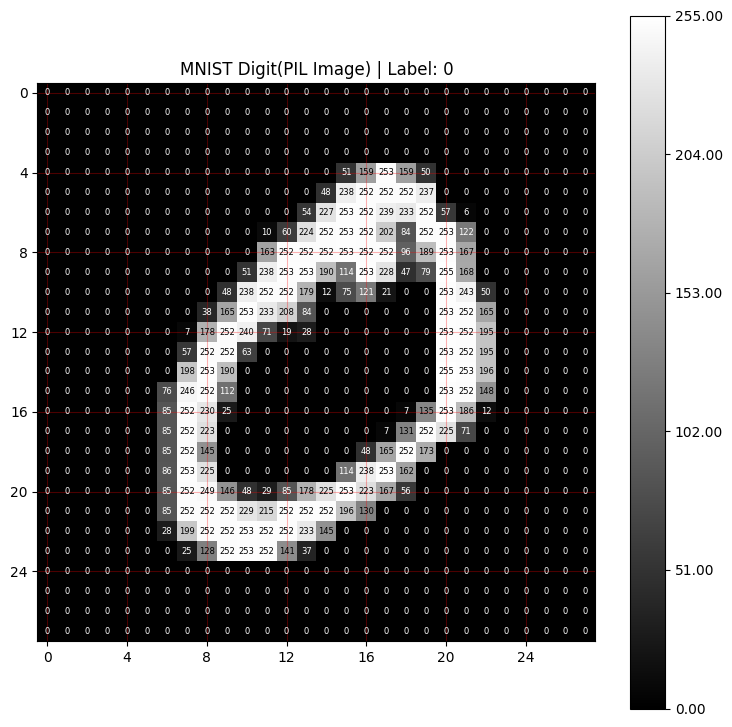

In [26]:
# Visua;ize the sample image and its corresponding label
helper_utils2.display_image(image_pil, label, "MNIST Digit(PIL Image)", show_values=True)

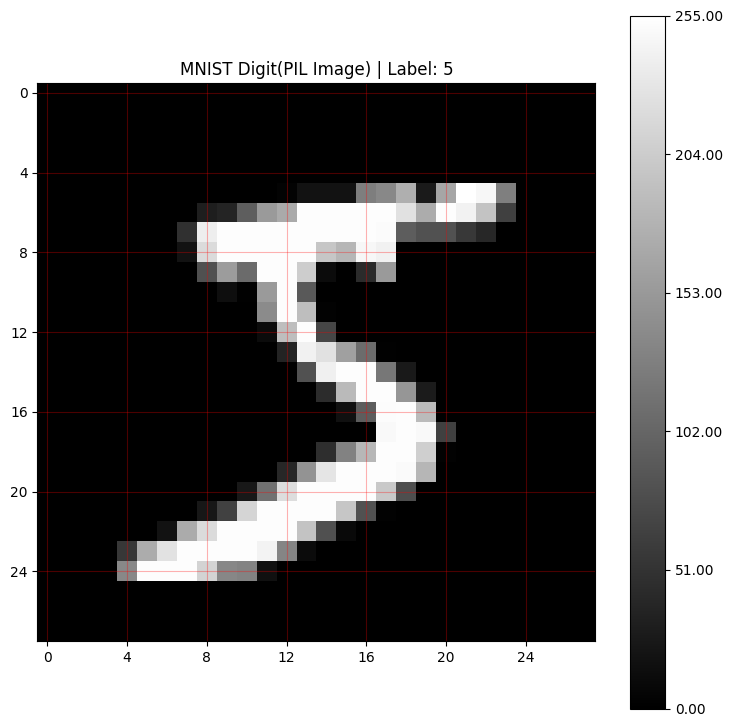

In [12]:
# Visua;ize the sample image and its corresponding label
helper_utils2.display_image(image_pil, label, "MNIST Digit(PIL Image)", show_values=False)

#### Loading dataset and applying transform

In [14]:
# Convert images to tensors and normaluize the pixel values

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081)) #MNIST mean and std
])

In [15]:
train_dataset = torchvision.datasets.MNIST(root=data_path, train=True, download=True, transform=transform)

In [16]:
# Access the first data again
image_tensor, label = train_dataset[0] 

print(f"Image Type:                   {type(image_tensor)}")
# Since the `image` is now a PyTorch Tensor, its dimensions are accessed using the .shape attribute.
print(f"Image Shape After Transform:  {image_tensor.shape}")
print(f"Label Type:                   {type(label)}")
print(f"Label value:                  {label}")

Image Type:                   <class 'torch.Tensor'>
Image Shape After Transform:  torch.Size([1, 28, 28])
Label Type:                   <class 'int'>
Label value:                  5


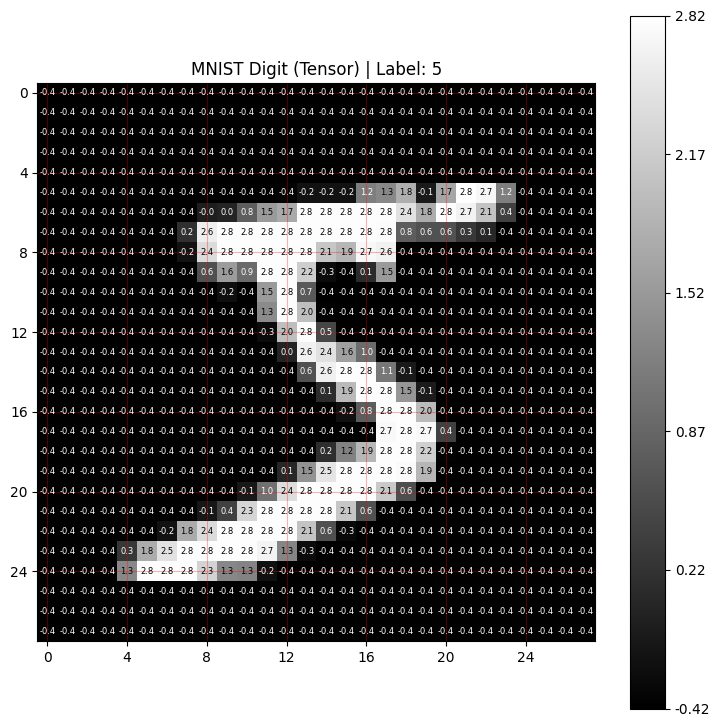

In [20]:
# Visualize the transformed image and its label
helper_utils2.display_image(image_tensor, label, "MNIST Digit (Tensor)", show_values=True)

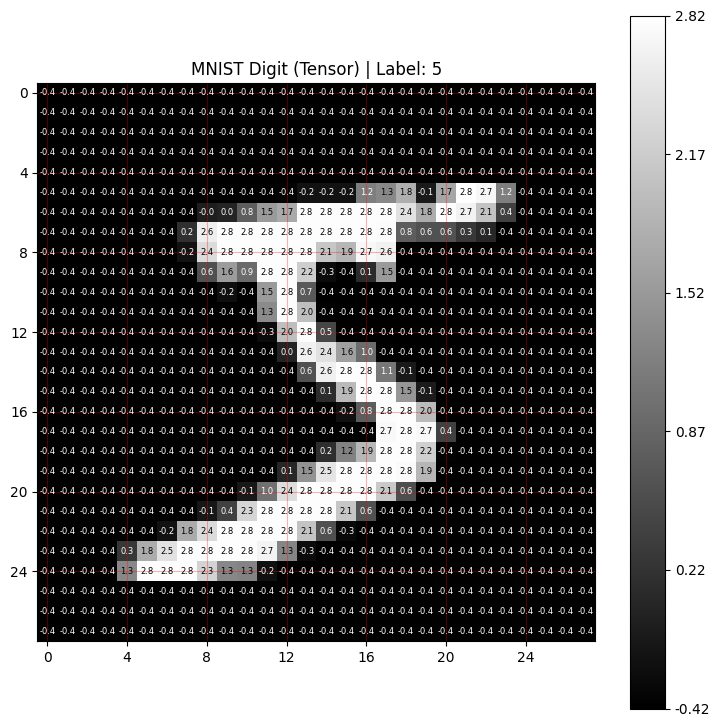

In [18]:
# Visualize the transformed image and its label
helper_utils2.display_image(image_tensor, label, "MNIST Digit (Tensor)", show_values=True)

In [ ]:
test_dataset = torchvision.datasets.MNIST(root=data_path, train=False, download=True, transform=transform)

In [ ]:
# Create a data loader for the trainin g set with shufflingenables
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create a data loader for the test set with a larger batch size and no shuffling
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)

In [29]:
class SimpleMNISTDNN(nn.Module):
  """
  A simple deep neural network model for the MNIST dataset.

  This model consists of a flatten layer followed by two linear layers
  with a ReLU activation function. It is designed for classification tasks
  on 28x28 grayscale images.
  """
  def __init__(self):
    """
    Initializes the layers of the neural network.
    """
    super(SimpleMNISTDNN, self).__init__()
    # Initializes a layer to flatten the input tensor
    # 28 x 28 input image to a 784-dimensional vector
    self.flatten = nn.Flatten()
    self.layers = nn.Sequential(
      nn.Linear(784, 128),
      nn.ReLU(),
      nn.Linear(128, 10)
    )

  def forward(self, x):
      """
      Defines the forward pass of the model.

      Args:
        x: The input tensor.

      Returns:
        The output tensor after passing through the network layers.
    """
     
    #  Flattens the inout tensor
      x = self.flatten(x)
    # Passes the flattened tensor through the sequential layers
      x = self.layers(x)
      return x


In [31]:
# Initialize the neural network model
model = SimpleMNISTDNN()

# Define the loss function, suitable for multi-class calssification
loss_function = nn.CrossEntropyLoss()

# Setup the optimizer and update the models parameter with a learning rate of 0.001
optimizer =optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_epoch(model, loss_function, optimizer, train_loader, device):
    """
    Trains a PyTorch model for a single epoch.

    This function iterates over the training dataset, performs the forward and
    backward passes, and updates the model's weights. It also tracks and
    prints the loss and accuracy at specified intervals.

    Args:
        model: The neural network model to be trained.
        loss_function: The loss function used to calculate the error.
        optimizer: The optimizer used to update the model's weights.
        train_loader: The DataLoader providing batches of training data.
        device: The device (e.g., 'cuda' or 'cpu') on which to perform training.

    Returns:
        A tuple containing:
        - model: The model after training for one epoch.
        - avg_epoch_loss: The average loss calculated over all batches in the epoch.
      """
    
    # Ensure the model is on the correct device for training
    model = model.to(device)
    # Set the model to trainng mode
    model.train()

    # Initialize trackers for the entire epoch's loss
    epoch_loss = 0.0

    # Initialize trackers for periodic progress reporting
    running_loss = 0.0
    num_correct_predictions = 0
    total_predictions = 0
    total_batches = len(train_loader)

    # Iterate over the training data in batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move the current batch of data to the specified davice
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear any gradients from the previous iteration
        optimizer.zero_grad()

        # Perform a forward pass to get model predictions
        outputs = model(inputs)

        # Calculate the loss for the current batch
        loss = loss_function(outputs, targets)

        # Perform backward propagation to compute gradients
        loss.backward()

        # Update the model's weights based on the computed gradients
        optimizer.step()

        # Accumulate the loss for tracking and reporting
        loss_value = loss.item()
        epoch_loss += loss_value
        running_loss += loss_value

        # Calculate accuracy metrics for the current batch
        _, predicted_indices = outputs.max(1)
        batch_size = targets.size(0)
        total_predictions += batch_size
        num_correct_in_batch = predicted_indices.eq(targets).sum().item()
        num_correct_predictions += num_correct_in_batch

        # Check if it's time to print a progress update
        if (batch_idx + 1) % 134 == 0 or (batch_idx + 1) == total_batches:
            # Calculate average loss and accuracy for the current interval
            avg_running_loss = running_loss / 134
            accuracy = 100. * num_correct_predictions / total_predictions
            
            # Print the progress update
            print(f'\tStep {batch_idx + 1}/{total_batches} - Loss: {avg_running_loss:.3f} | Acc: {accuracy:.2f}%')
            
            # Reset the trackers for the next reporting interval
            running_loss = 0.0
            num_correct_predictions = 0
            total_predictions = 0
            
    # Calculate the average loss for the entire epoch
    avg_epoch_loss = epoch_loss / total_batches
    # Return the trained model and the average epoch loss
    return model, avg_epoch_loss